# NSMC on a square lattice model

In this notebook we implement NSMC on a square lattice model and a slightly adapated version with QMC.

We compare those two algorithms in terms of prediction and variance.

The square lattice model is a high dimensional SSM.
The latent variable is Gaussian with local dependencies (square dependencies) and the data is distributed according to a Poisson distribution of parameter the exponential of the latent variable.

In [10]:
library(RSQMC) # homemade Rcpp package for internal filter functions
library(MASS) # for multivariate Gaussian simulation : function mvrnorm
library(parallel)

library(ggplot2) # plotting library

source(file.path(getwd(), "Lattice_Model_Functions.R"))

#library(mvtnorm)

set.seed(41)

### Parameters

In [11]:
T_ <- 40 # time
D <- 8 # dimension -> DxD square
N <- 50 # number of external particles
M <- 32 # number of internal particles
tau <- 1. # coordinates variance
lambda <- 1. # coordinates correlation

# AR(1) parameters / arbitrarily chosen
mu = 3
rho = 0.9

In [12]:
# Covariance matrix design
S_inv <- matrix(0, D**2, D**2)

for(n in 1:D){
  for(k in 1:D){
    nb_neighbours = 0
    # (n,k) gives n*D + k position in vector
    vector_index <- (n-1)*D + k
    if (n > 1){ # upper neighbour
      S_inv[vector_index, vector_index - D] <- (-lambda)
      nb_neighbours = nb_neighbours + 1
    }
    if (n < D){ # lower neighbour
      S_inv[vector_index, vector_index + D] <- (-lambda)
      nb_neighbours = nb_neighbours + 1
    }
    if(k > 1){ # left neighbour
      S_inv[vector_index, vector_index - 1 ] <- (-lambda) 
      nb_neighbours = nb_neighbours + 1
    }
    if (k < D){ # right neighbour
      S_inv[vector_index, vector_index + 1] <- (-lambda)
      nb_neighbours = nb_neighbours + 1
    }
    S_inv[vector_index, vector_index] = tau + 2*nb_neighbours*lambda
  }
}

S <- solve(S_inv) # covariance matrix

### Trajectories simulation

In [13]:
x <- matrix(0, D**2, T_)
y <- matrix(0, D**2, T_)

x[, 1] <- mvrnorm(n = 1, matrix(mu, D**2), S)
for(d in 1:(D**2)){
  y[d, 1] <- rpois(1, exp(x[d, 1]))
  #y[d, 1] <- rnorm(n=1, x[d, 1], 1)
}

for(t in 2:T_){
  x[, t] <- mu + rho*(x[, t-1]-mu) + mvrnorm(n = 1, matrix(0, D**2), S)
  #y[, t] <- mvrnorm(n=1, x[, t], diag(1, D**2))
  for(d in 1:(D**2)){
    y[d, t] <- rpois(1, exp(x[d, t]))
    
  }
}

### Prediction comparison

In [14]:
#### NSMC without QMC
particles <- lattice_filter(y, N, M, D, T_, mu, rho, S, QMC=FALSE)

#### NSMC with QMC
particles_QMC <- lattice_filter(y, N, M, D, T_, mu, rho, S, QMC=TRUE)

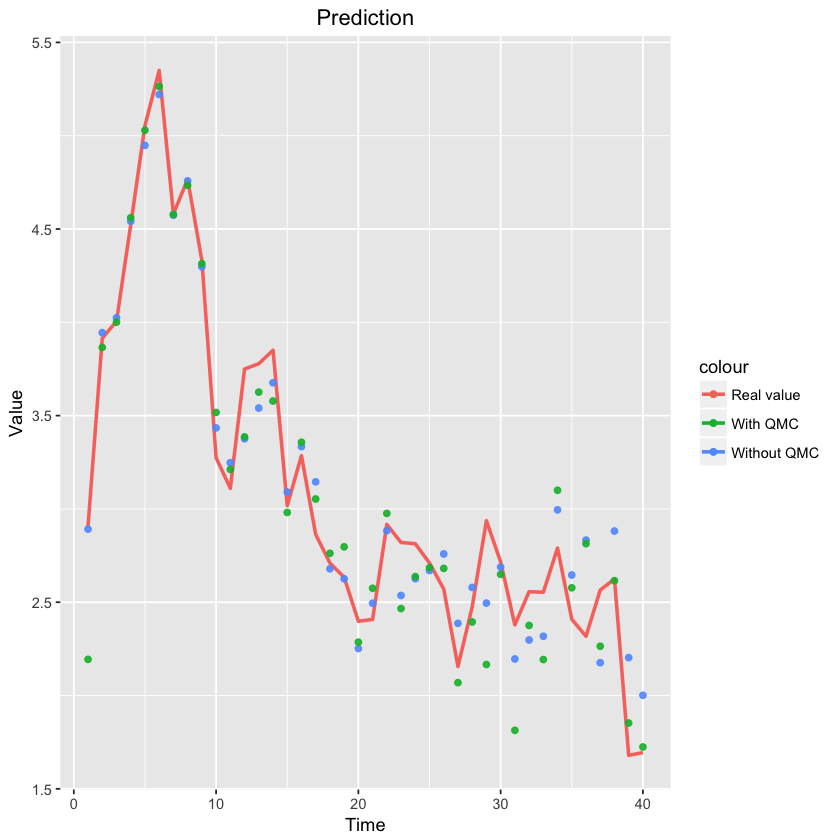

In [15]:
plot_coordinate = 1
df = data.frame(real_value = x[plot_coordinate, ], 
                no_QMC = apply(particles[, plot_coordinate, ], 2, mean), 
                QMC = apply(particles_QMC[, plot_coordinate, 1:T_], 2, mean))

df$idu <- as.numeric(row.names(df))

prediction_plot <- (ggplot(df) + geom_line(aes(x=idu, y=real_value, color='Real value'), size=1) + 
 geom_point(aes(x=idu, y=no_QMC, color='Without QMC'), alpha=0.9) + 
 geom_point(aes(x=idu, y=QMC, color='With QMC'), alpha=0.9) + 
 labs(title='Prediction') + 
 xlab('Time') + ylab('Value') +
 theme(plot.title = element_text(hjust = 0.5)))

savename <- paste('plots/prediction/prediction_plot_', D,'_', N, '_', M, '.pdf', sep="")
ggsave(filename=savename, plot=prediction_plot, height=5,width=12,dpi=72)

prediction_plot

### Variance comparison

In [16]:
var = array(0, T_)
var_QMC = array(0, T_)

nb_filters <- 10 # number of replications

cl <- makeCluster(2)
clusterExport(cl=cl, varlist=c("y", "N", "M", "D", "T_", "mu", "rho", "S", 
                               "lattice_filter", "mvrnorm", 
                               "observation_lh", "lattice_internal_filter", 
                               "lattice_internal_filter_QMC"))
var <- apply(parSapply(cl, 1:nb_filters, lattice_filter_replicate), 1, var)
var_QMC <- apply(parSapply(cl, 1:nb_filters, lattice_filter_QMC_replicate), 1, var)
stopCluster(cl)

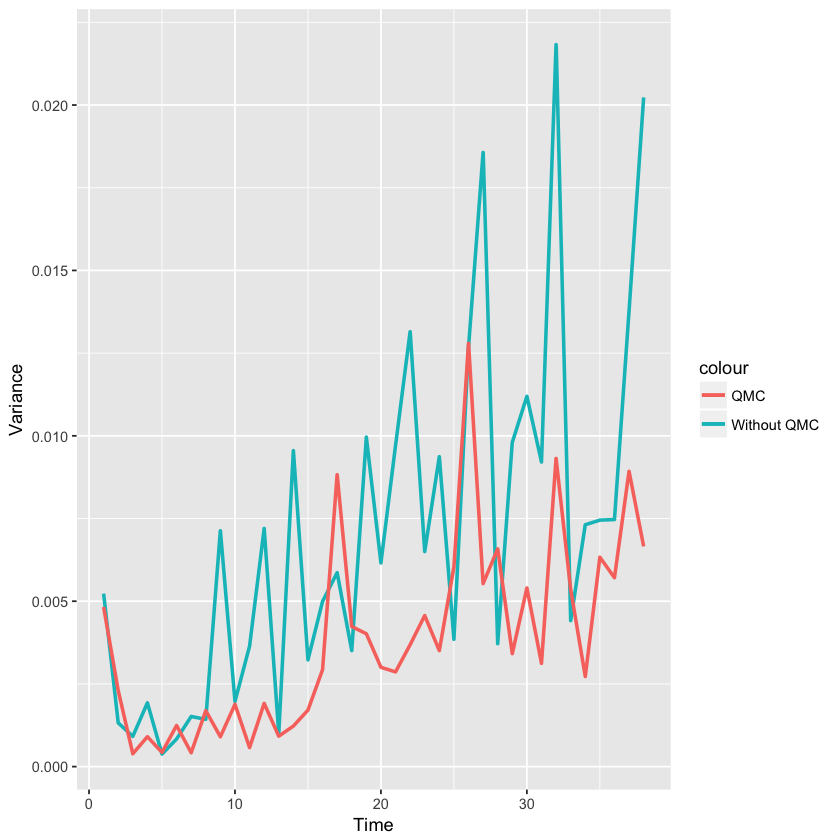

In [18]:
df <- data.frame(no_QMC = var[3:T_-1], QMC = var_QMC[3:T_-1])
df$idu <- as.numeric(row.names(df))

var_plot <- (ggplot(df) + geom_line(aes(x=idu, y=no_QMC, color='Without QMC'), size=1) + 
geom_line(aes(x=idu, y=QMC, color='QMC'), size=1) + xlab("Time") + ylab("Variance")) 

savename <- paste('plots/variance/variance_lattice_', D**2,'_', N, '_', M, '.pdf', sep="")
ggsave(filename=savename, plot=var_plot, height=5, width=12, dpi=72)

var_plot